# Analyse de données BottleNeck v1 (02/2023, Kamel Badar)

# 1 Introduction

Ce notebook sera divisé en plusieurs parties : 
- L'import des données et la vérification de leur intégrité 
- Le regroupement des fichiers sources afin de constituer une base de données exploitable
- La conduite d'analyses afin de répondre aux premières demandes

## 1.1 Importation des librairies

In [1]:
# Importation de x librairies pour la manipulation et l'analyse des données
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 1.2 Importation des données 

In [2]:
# On importe les fichiers et on les assigne à des dataframes 
dataWeb = pd.read_excel('web.xlsx')
dataWeb = dataWeb.rename(columns={'id_web':'sku'})

dataErp = pd.read_excel('erp.xlsx')

dataLiaison = pd.read_excel('liaison.xlsx')
dataLiaison = dataLiaison.rename(columns={'id_web':'sku'})

In [41]:
# Vérification du chargement de chaque DF
dataWeb

,sku,total_sales,post_date,post_title,post_name,post_type
0,38,38.0,2018-04-18 12:25:58,Emile Boeckel Crémant Brut Blanc de Blancs,emile-boeckel-cremant-brut-blanc-de-blancs,product
1,38,38.0,2018-04-18 12:25:58,Emile Boeckel Crémant Brut Blanc de Blancs,emile-boeckel-cremant-brut-blanc-de-blancs,attachment
2,41,0.0,2018-04-14 12:01:43,Marcel Windholtz Eau de Vie de Marc de Gewurzt...,marcel-windholtz-eau-de-marc-de-gewurztraminer,product
3,41,0.0,2018-04-14 12:01:43,Marcel Windholtz Eau de Vie de Marc de Gewurzt...,marcel-windholtz-eau-de-marc-de-gewurztraminer,attachment
4,304,40.0,2018-02-13 12:57:44,Champagne Gosset Grande Réserve,gosset-champagne-grande-reserve,product
...,...,...,...,...,...,...
1447,NaN,NaN,NaT,NaN,NaN,NaN
1448,NaN,NaN,NaT,NaN,NaN,NaN
1449,NaN,NaN,NaT,NaN,NaN,NaN
1450,NaN,0.0,2018-07-31 12:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,pierre-jean-villa-cote-rotie-fongeant-2017,product


In [42]:
dataErp

,product_id,price
0,4041,32.7
1,4042,31.2
2,4043,60.0
3,4045,42.6
4,4047,18.3
...,...,...
820,6578,40.0
821,6751,46.5
822,6886,42.0
823,6900,30.0


In [43]:
dataLiaison

,product_id,sku
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13128
823,7329,14681


Les données ont été correctement chargées dans nos dataframes.

## 1.3 DF dataErp

In [6]:
# On crée un DF sans les colonnes qui ne serviront pas pour cette analyse pour plus de visibilité

dataErp2 = dataErp[['product_id','price']]

In [7]:
# On analyse les types de données des différentes colonnes du DF
dataErp2.dtypes

product_id      int64
price         float64
dtype: object

Les types de données semblent adéquats

In [8]:
# On cherche la présence de valeurs nulles dans le DF
dataErp2.isna().sum()

product_id    0
price         0
dtype: int64

Il n'y a pas de valeur manquante

In [9]:
# On cherche la présence de doublons dans le DF
dataErp2.duplicated('product_id').any()

False

Pas de doublon dans la colonne 'product_id'

## 1.4 DF dataWeb

In [10]:
# On crée un DF sans les colonnes qui ne serviront pas pour cette analyse pour plus de visibilité 

dataWeb2 = dataWeb[['sku', 'total_sales','post_title','post_type']]


In [11]:
# On modifie le DF de sorte à garder uniquement les informations concernant les produits
# car la valeur 'attachment' pour la colonne 'post_type' génère des doublons 
dataWeb2 = dataWeb2[dataWeb2['post_type']=='product']

In [12]:
# On analyse les types de données des différentes colonnes du DF
dataWeb2.dtypes

sku             object
total_sales    float64
post_title      object
post_type       object
dtype: object

Le type de 'sku' est object alors qu'il devrait à priori être integer. Il faut vérifier les valeurs de la colonne pour savoir si un changement de type est envisageable.
Le type de 'total_sales' est float alors qu'il devrait également être integer car les ventes sont toujours exprimées par un entier. 

### 1.4.1 Colonne 'sku'

In [13]:
# Création d'une fonction afin d'identifier les valeurs ayant le type string dans la colonne sku
for value in dataWeb2['sku']:
    if isinstance(value, str):
        print(value, "is a string.")

13127-1 is a string.
bon-cadeau-25-euros is a string.


On constate qu'il y a 2 resultats renvoyés ce qui signifie que ces valeurs sont de type string.

In [14]:
# On transforme la chaîne de caractère par un integer
dataWeb2.loc[dataWeb2['sku'] == 'bon-cadeau-25-euros', 'sku'] = 37

On choisit 37 car c'est la plus petite valeur pour le SKU à laquelle on soustrait 1 (38-1)

In [15]:
# On transforme la chaîne de caractère par un integer
dataWeb2.loc[dataWeb2['sku'] == '13127-1', 'sku'] = 13128

On choisit 13128 car ce n'est pas une valeur présente dans le DF et que 13127 existe déjà et correspond au même vin mais issu d'une année différente (2020 vs 2007)

In [16]:
# On réexécute la fonction afin de contrôler si il reste des chaînes de caractères
for value in dataWeb2['sku']:
    if isinstance(value, str):
        print(value, "is a string.")

Rien ne s'affiche, il n'y a donc plus de chaînes de caractères

In [17]:
# On supprime les valeurs manquantes
dataWeb2.dropna(inplace=True)

In [18]:
# On contrôle le nombre de valeurs manquantes après la manipulation
dataWeb2.isna().any()

sku            False
total_sales    False
post_title     False
post_type      False
dtype: bool

Il n'y a plus de valeur manquante, on peut convertir la colonne au type integer

In [19]:
# On convertit la colonne sku en integer
dataWeb2['sku'] = dataWeb2['sku'].astype(int)
dataWeb2.dtypes

sku              int32
total_sales    float64
post_title      object
post_type       object
dtype: object

#### 1.4.2 Colonne 'total_sales'

In [20]:
# On convertit la colonne au type integer

dataWeb2['total_sales'] = dataWeb2['total_sales'].astype(int)
dataWeb2.dtypes

sku             int32
total_sales     int32
post_title     object
post_type      object
dtype: object

### 1.5 DF dataLiaison

In [21]:
# Analyse des types de données 
dataLiaison.dtypes

product_id     int64
sku           object
dtype: object

In [22]:
# On utilise à nouveau la fonction afin de détecter les chaînes de caractères
for value in dataLiaison['sku']:
    if isinstance(value, str):
        print(value, "is a string.")

bon-cadeau-25-euros is a string.
13127-1 is a string.
14680-1 is a string.


In [23]:
# On transforme la chaîne de caractère par un integer
dataLiaison.loc[dataLiaison['sku'] == 'bon-cadeau-25-euros', 'sku'] = 37

In [24]:
# On transforme la chaîne de caractère par un integer
dataLiaison.loc[dataLiaison['sku'] == '13127-1', 'sku'] = 13128

In [25]:
# On transforme la chaîne de caractère par un integer
dataLiaison.loc[dataLiaison['sku'] == '14680-1', 'sku'] = 14681

On applique la même logique que le DF dataWeb2

In [26]:
# Detection des doublons
dataLiaison.duplicated().any()

False

Il n'y a aucun doublons

In [27]:
# Detection des valeurs manquantes
dataLiaison.isna().sum()

product_id     0
sku           91
dtype: int64

Il y a 91 valeurs manquantes pour la colonne 'sku' ce qui est normal compte tenu des commentaires de Sylvie, chargée du rapprochement des 'product_id' avec le 'sku', qui précise : "la liste des product_id est exhaustive, mais pour les références côté Web, j’en suis moins sûre... J’ai peiné à rapprocher certaines références."

## 2 Fusion des DF

La jointure entre les fichiers se fait en 2 étapes : 
- Une jointure interne entre le fichier ERP et le fichier de liaison 
- Une jointure à gauche entre le nouveau fichier issu de la précédente opération et le fichier Web

In [28]:
# On effectue une jointure interne 
mergeErpLiaison = pd.merge(dataErp2, dataLiaison, on ='product_id')
mergeErpLiaison 

,product_id,price,sku
0,4041,32.7,14975
1,4042,31.2,16042
2,4043,60.0,14980
3,4045,42.6,16041
4,4047,18.3,14977
...,...,...,...
820,6578,40.0,15647
821,6751,46.5,16144
822,6886,42.0,14897
823,6900,30.0,NaN


In [29]:
dataVentes = pd.merge(mergeErpLiaison, dataWeb2, on ='sku', how='left')
dataVentes

,product_id,price,sku,total_sales,post_title,post_type
0,4041,32.7,14975,0.0,Pierre Gaillard Condrieu 2018,product
1,4042,31.2,16042,7.0,Pierre Gaillard Cornas 2017,product
2,4043,60.0,14980,3.0,Pierre Gaillard Côte Rôtie Esprit de Blonde 2017,product
3,4045,42.6,16041,14.0,Pierre Gaillard Côte Rôtie 2018,product
4,4047,18.3,14977,0.0,Pierre Gaillard Côtes-du-Rhône Blanc Les Gendr...,product
...,...,...,...,...,...,...
820,6578,40.0,15647,7.0,Saumaize-Michelin Pouilly-Fuissé Ampélopsis 2016,product
821,6751,46.5,16144,0.0,Château Simone Palette Blanc 2017,product
822,6886,42.0,14897,0.0,Gratavinum Priorat GV5 2011,product
823,6900,30.0,NaN,NaN,NaN,NaN


## 3 Analyse des données de vente 

### 3.1 Chiffre d'affaire

In [51]:
# Calcul du chiffre d'affaires par produit 

dataVentes['caProduit'] = dataVentes['price']*dataVentes['total_sales']
dataVentes.sort_values('caProduit', ascending=False).head(10)


,product_id,price,sku,total_sales,post_title,post_type,caProduit
688,4334,49.0,7818,96.0,Champagne Gosset Grand Blanc de Blancs,product,4704.0
53,4144,49.0,1662,87.0,Champagne Gosset Grand Rosé,product,4263.0
169,4402,176.0,3510,13.0,Cognac Frapin VIP XO,product,2288.0
52,4142,53.0,11641,30.0,Champagne Gosset Grand Millésime 2006,product,1590.0
51,4141,39.0,304,40.0,Champagne Gosset Grande Réserve,product,1560.0
158,4355,126.5,12589,11.0,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,product,1391.5
689,4352,225.0,15940,5.0,Champagne Egly-Ouriet Grand Cru Millésimé 2008,product,1125.0
660,4153,29.0,16237,36.0,Elian Daros Côtes du Marmandais Clos Baquey 2015,product,1044.0
530,6206,25.2,16580,41.0,Domaine Giudicelli Patrimonio Blanc 2019,product,1033.2
20,4068,16.6,16416,62.0,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,product,1029.2


In [31]:
# Calcul du chiffre d'affaires global pour les produits vendus en ligne
caTotal = dataVentes['caProduit'].sum()
caTotal

70568.6

Le chiffre d'affaires total est de 70 568€

### 3.2 Analyse de la variable prix

#### 3.2.1 Distribution empirique de la variable

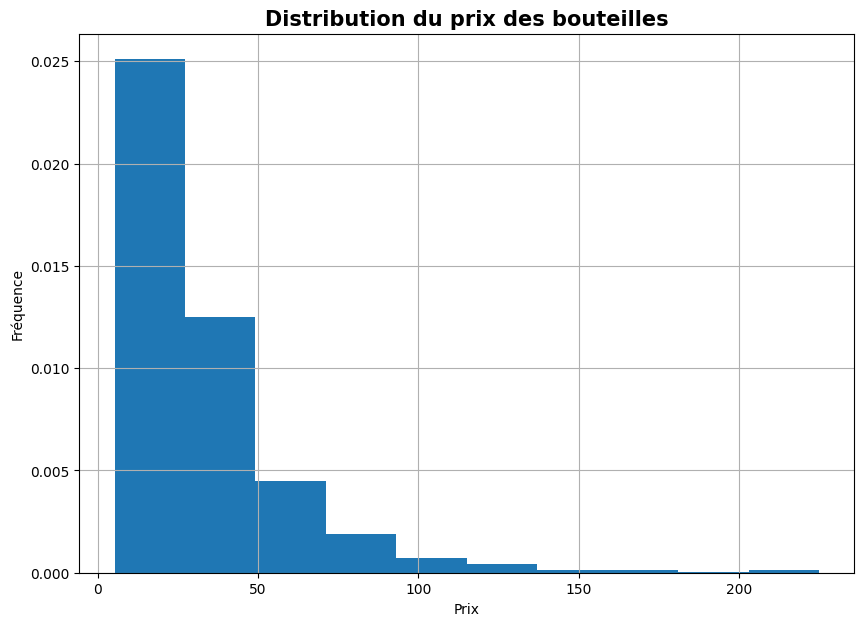

In [32]:
# On visualise la distribution empirique de la variable à travers un histogramme
plt.figure(figsize=(10,7))
dataVentes['price'].hist(density=True)
plt.title("Distribution du prix des bouteilles", fontsize=15, fontweight='bold')
plt.xlabel("Prix")
plt.ylabel("Fréquence")
plt.show()

In [33]:
# On détermine les quartiles ainsi que l'écart interquartile
q1 = np.percentile(dataVentes["price"], 25)
q2 = np.percentile(dataVentes["price"], 50)
q3 = np.percentile(dataVentes["price"], 75)
iqr = q3-q1

In [34]:
print("Le premier quartile est de %.2f €, la médiane est de %.2f €, et le troisième quartile est de %.2f €. L'intervalle interquatile est %.2f €." % (q1, q2, q3, iqr))


Le premier quartile est de 14.60 €, la médiane est de 24.40 €, et le troisième quartile est de 42.00 €. L'intervalle interquatile est 27.40 €.


#### 3.2.2 Analyse des outliers

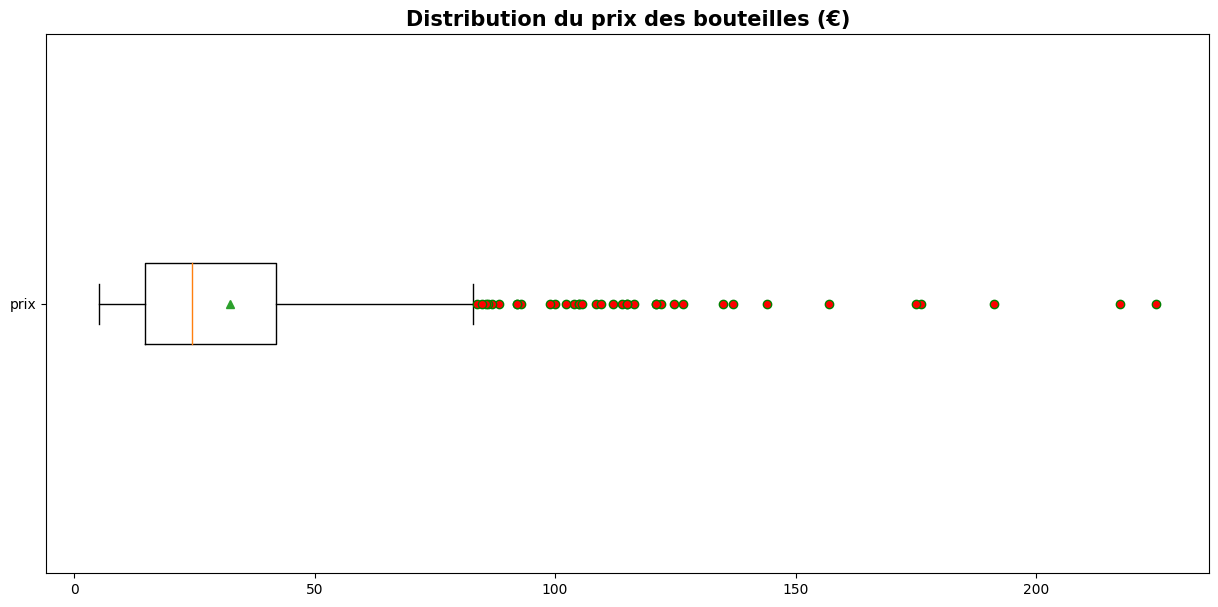

In [35]:
# On crée un boxplot pour visualiser les outliers
plt.figure(figsize=(15,7))
flierprops = dict(marker='o', markerfacecolor='r', markeredgecolor='g', markersize=6)
plt.boxplot(dataVentes['price'], vert=False, labels=['prix'], showmeans=True, flierprops=flierprops)
plt.title("Distribution du prix des bouteilles (€)", size=15, fontweight='bold')
plt.show()

In [36]:
limitOutlier = q3 + 1.5*iqr 
print(limitOutlier)

83.1


Ainsi, toute valeur au delà de 83,10€ est une valeur atypique. 
Voici la liste des bouteilles concernés : 

In [37]:
# 1ere méthode

dataVentes[dataVentes["price"]> limitOutlier][[ "product_id","post_title", "price", "total_sales"]].sort_values(by="price", ascending=False)


,product_id,post_title,price,total_sales
689,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0
351,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5,0.0
481,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,3.0
169,4402,Cognac Frapin VIP XO,176.0,13.0
453,5767,Camille Giroud Clos de Vougeot 2016,175.0,0.0
172,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,0.0
698,4594,NaN,144.0,NaN
319,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,5.0
522,6126,Champagne Gosset Célébris Vintage 2007,135.0,2.0
158,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0


In [38]:
# 2eme méthode 

zScore=dataVentes[["post_title","product_id","total_sales","price"]]
zScore.sort_values(by="price", inplace = True)
zScore["zscores"] = stats.zscore(zScore["price"])
mask = (zScore["zscores"] > 2)
print(zScore[mask])

                                            post_title  product_id  \
647                                                NaN        4055   
359  Champagne Agrapart &amp; Fils Minéral Extra Br...        5026   
49   Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...        4132   
545                                                NaN        6324   
774                      Tempier Bandol Cabassaou 2017        5565   
492  Wemyss Malts Single Cask Scotch Whisky Chocola...        5916   
534  Domaine des Comtes Lafon Volnay 1er Cru Champa...        6214   
48   Zind-Humbrecht Riesling Grand Cru Rangen De Th...        4115   
318  Domaine Des Croix Corton Grand Cru Les Grèves ...        4903   
173                          Cognac Frapin Cigar Blend        4407   
356  Domaine des Comtes Lafon Volnay 1er Cru Santen...        5008   
355  Domaine des Comtes Lafon Volnay 1er Cru Santen...        5007   
526  David Duband Chambolle-Musigny 1er Cru Les Sen...        6201   
170              Cog

C:\Users\kamel\AppData\Local\Temp\ipykernel_21832\2727795776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zScore.sort_values(by="price", inplace = True)
C:\Users\kamel\AppData\Local\Temp\ipykernel_21832\2727795776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zScore["zscores"] = stats.zscore(zScore["price"])


In [39]:
dataVentes['price'].describe()

count    825.000000
mean      32.415636
std       26.795849
min        5.200000
25%       14.600000
50%       24.400000
75%       42.000000
max      225.000000
Name: price, dtype: float64

In [40]:
dataVentes[dataVentes["price"]> limitOutlier]["price"].mean()

120.9945945945946

On constate que le prix moyen des bouteilles outlier est de 121€ environ alors qu'il est de 32€ environ pour l'ensemble des bouteille

#### 3.2.3 Que faire des valeurs atypiques ? 

Lorsque l'on se penche sur les bouteilles qui ont un prix que l'on pourrait considérer comme valeur aberrante, on peut se rendre compte que cela n'est manifestement pas lié à une erreur de saisie ou à un problème informatique quelconque. Les bouteilles concernées portent souvent l'appellation "grand cru", "1er cru", et sont souvent des champagnes ce qui laisse penser qu'il s'agit donc uniquement de bouteilles haut de gamme. Nous prenons donc la décision de ne pas les supprimer. 